In [47]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(style="white")

from sklearn import linear_model

from datetime import datetime

from sklearn.model_selection import train_test_split

In [ ]:
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import load_model

In [2]:
# Read in the accident data. Each unique accident in the accident data can have multiple 
# casualties and vehicles
accident_data = pd.read_csv('dftRoadSafety_Accidents_2016.csv', 
                            dtype={"Did_Police_Officer_Attend_Scene_of_Accident": int})

# Extract month from date
def month_from_date(date):
    dmyyyy = datetime.strptime(date, '%d/%m/%Y')
    return int(datetime.strftime(dmyyyy, '%m'))

accident_data['Month_of_Year'] = accident_data['Date'].apply(month_from_date)

# Extract hour from time
def hour_from_time(time):
    try:
        hhmm = datetime.strptime(time, '%H:%M')
        return int(datetime.strftime(hhmm, '%H'))
    except Exception:
        # Some times are nan
        return 0

accident_data['Hour_of_Day'] = accident_data['Time'].apply(hour_from_time)

# Drop columns which cannot be used as predictors of cycling accidents
accident_data = accident_data.drop(['Number_of_Vehicles', 'Local_Authority_(District)', 
                                    'Police_Force', 'Location_Easting_OSGR', 
                                    'Location_Northing_OSGR',
                                    '1st_Road_Class', 'Road_Type', 'Date', 'Time', 
                                    'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 
                                    '2nd_Road_Number', 'Special_Conditions_at_Site', 
                                    'Carriageway_Hazards', 'Number_of_Casualties',
                                    'Pedestrian_Crossing-Physical_Facilities', 
                                    'Pedestrian_Crossing-Human_Control',
                                    'Did_Police_Officer_Attend_Scene_of_Accident', 
                                    'Local_Authority_(Highway)', 
                                    'LSOA_of_Accident_Location', 'Accident_Severity', 
                                    '1st_Road_Number'], axis=1)

# Remove rows where latitude or longitude is NaN
accident_data = accident_data[np.isfinite(accident_data['Longitude'])]
accident_data = accident_data[np.isfinite(accident_data['Latitude'])]

accident_data.head()

C:\Users\Spencer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Accident_Index,Longitude,Latitude,Day_of_Week,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day
0,2016010000005,-0.279323,51.584754,3,30.0,5,1,1,1,11,2
1,2016010000006,0.184928,51.449595,3,30.0,4,1,1,1,11,0
2,2016010000008,-0.473837,51.543563,3,30.0,4,1,1,1,11,1
3,2016010000016,-0.164442,51.404958,3,30.0,1,1,1,1,11,9
4,2016010000018,-0.406580,51.483139,3,40.0,1,1,1,1,11,7


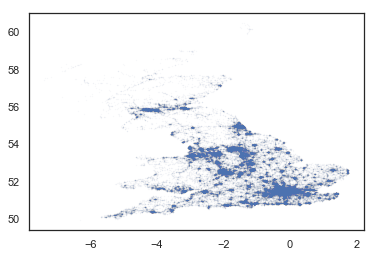

In [53]:
plt.plot(accident_data.Longitude, accident_data.Latitude, 'b.', ms=0.5,alpha=0.07)

In [4]:
print ("There are", len(accident_data.index), "unique accidents")

There are 136614 unique accidents


In [40]:
# Read in the casualty data
casualty_data = pd.read_csv('Cas.csv')
casualty_data = casualty_data[casualty_data.Casualty_Type==1]

# Drop columns which cannot be used as predictors of age accidents
casualty_data = casualty_data.drop(['Bus_or_Coach_Passenger', 'Car_Passenger', 
                                    'Pedestrian_Movement', 'Pedestrian_Location', 
                                    'Casualty_Reference', 'Vehicle_Reference', 
                                    'Casualty_Class',
                                    'Casualty_Severity', 'Casualty_IMD_Decile', 
                                    'Pedestrian_Road_Maintenance_Worker'], axis=1)
casualty_data.head()

,Accident_Index,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Type,Casualty_Home_Area_Type
4,2016010000018,1,28,6,1,1
17,2016010000046,1,20,4,1,1
29,2016010000058,1,23,5,1,1
35,2016010000069,1,29,6,1,1
36,2016010000072,1,24,5,1,1


(0.0, 910.0)

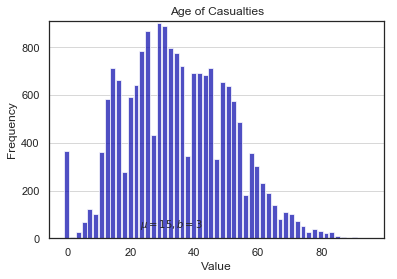

In [41]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=casualty_data['Age_of_Casualty'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Age of Casualties')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [49]:
print ("There are", len(casualty_data.index), "casualties")

There are 18477 casualties


In [43]:
# Merge accident and casualty data for cycling accidents
casualty_and_accident_data = pd.merge(accident_data, casualty_data, on='Accident_Index', 
                                      how='left')
casualty_and_accident_data = casualty_and_accident_data.drop(['Accident_Index'], axis=1)

# Replace NaN with zero
casualty_and_accident_data.fillna(0, inplace=True)

# Casualty data after merge is cast to float. Cast back to integer
casualty_and_accident_data['Casualty_Type'] = casualty_and_accident_data['Casualty_Type'].astype(int)

# We will use Casualty_Type as an indicator of a cycling accident. If 1 it is a cycling accident and if 0 a non-cycling accident
casualty_and_accident_data = casualty_and_accident_data.rename(columns={'Casualty_Type': 'Cycling_Accident'})

# Display our data
casualty_and_accident_data

,Longitude,Latitude,Day_of_Week,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Cycling_Accident,Casualty_Home_Area_Type
0,-0.279323,51.584754,3,30.0,5,1,1,1,11,2,0.0,0.0,0.0,0,0.0
1,0.184928,51.449595,3,30.0,4,1,1,1,11,0,0.0,0.0,0.0,0,0.0
2,-0.473837,51.543563,3,30.0,4,1,1,1,11,1,0.0,0.0,0.0,0,0.0
3,-0.164442,51.404958,3,30.0,1,1,1,1,11,9,0.0,0.0,0.0,0,0.0
4,-0.406580,51.483139,3,40.0,1,1,1,1,11,7,1.0,28.0,6.0,1,1.0
5,-0.121004,51.387813,3,30.0,1,1,1,1,11,9,0.0,0.0,0.0,0,0.0
6,-0.162234,51.517333,3,30.0,1,1,1,1,11,8,0.0,0.0,0.0,0,0.0
7,-0.213859,51.590341,3,30.0,1,1,1,1,11,10,0.0,0.0,0.0,0,0.0
8,-0.205302,51.510716,3,30.0,1,1,1,1,11,9,0.0,0.0,0.0,0,0.0
9,0.023193,51.453758,3,30.0,1,1,1,1,11,9,0.0,0.0,0.0,0,0.0


In [44]:
# Convert the latitude and longitude coordinates to area squares
latitude_min = min(casualty_and_accident_data['Latitude'])
latitude_max = max(casualty_and_accident_data['Latitude'])
longitude_min = min(casualty_and_accident_data['Longitude'])
longitude_max = max(casualty_and_accident_data['Longitude'])

# Determine the required step for a given number of areas
latitude_step = (latitude_max - latitude_min) / 1000
longitude_step = (longitude_max - longitude_min) / 1000

# Determine the latitude area
def calc_lat_area(current_lat):
    return int((current_lat - latitude_min) / latitude_step)

# Determine the longitude area
def calc_lon_area(current_lon):
    return int((current_lon - longitude_min) / longitude_step)

# Create new columns with the latitude and longitude areas
casualty_and_accident_data["Latitude_Area"] = list(map(calc_lat_area, casualty_and_accident_data["Latitude"]))
casualty_and_accident_data["Longitude_Area"] = list(map(calc_lon_area, casualty_and_accident_data["Longitude"]))

# Drop the old latitude and logitude columns
casualty_and_accident_data = casualty_and_accident_data.drop(['Longitude', 'Latitude'], axis=1)

# Display our data
casualty_and_accident_data.head()

,Day_of_Week,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Cycling_Accident,Casualty_Home_Area_Type,Latitude_Area,Longitude_Area
0,3,30.0,5,1,1,1,11,2,0.0,0.0,0.0,0,0.0,157,777
1,3,30.0,4,1,1,1,11,0,0.0,0.0,0.0,0,0.0,144,828
2,3,30.0,4,1,1,1,11,1,0.0,0.0,0.0,0,0.0,153,756
3,3,30.0,1,1,1,1,11,9,0.0,0.0,0.0,0,0.0,140,789
4,3,40.0,1,1,1,1,11,7,1.0,28.0,6.0,1,1.0,147,763


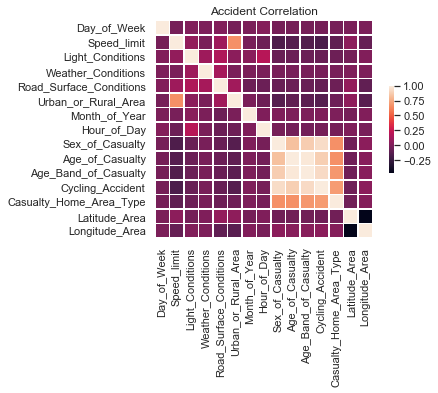

In [45]:
# Compute the correlation matrix
corr = casualty_and_accident_data.corr()

# Draw the correlation matrix
sns.heatmap(corr, square=True, linewidths=.4, cbar_kws={"shrink": .4})

plt.title("Accident Correlation")
plt.show()

In [50]:
# Split the data, 75% for training and 25% for validation
x_data = casualty_and_accident_data.drop(['Age_of_Casualty'], axis=1)
y_data = casualty_and_accident_data['Age_of_Casualty']

(trainData, testData, trainLabels, testLabels) = train_test_split(x_data.values, 
                                                                  y_data.values, 
                                                                  test_size=0.25, 
                                                                  random_state=42)